In [1]:
import pandas as pd
import numpy as np
from utils import reduction_function as rfun
from utils import polarization_function as pfun
import networkx as nx

/home/dara/miniconda3/envs/bach_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
net_file = pd.read_csv("../output_network/network_filtered.csv", sep="\t")
G = nx.from_pandas_edgelist(net_file, "src", "trg")
print(G)

Graph with 511 nodes and 2785 edges


## Loading the labelled message files

In [3]:
import csv

In [4]:
abortion_df = pd.read_csv("../llama_probs/llama_probabilities_full_abortion.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
marriage_df = pd.read_csv("../llama_probs/llama_probabilities_full_marriage.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)
political_df = pd.read_csv("../llama_probs/llama_probabilities_full_political.csv", sep="\t", encoding="utf-8", quoting=csv.QUOTE_NONE)

In [5]:
abortion_df.shape, marriage_df.shape, political_df.shape

((19939, 13), (13073, 13), (25360, 13))

In [6]:
abortion_df = abortion_df[["user", "text", "topic", "A", "F", "N"]]
marriage_df = marriage_df[["user", "text", "topic", "A", "F", "N"]]
political_df = political_df[["user", "text", "topic", "A", "F", "N"]]
political_df.head()

,user,text,topic,A,F,N
0,InterestingCry1789,"""""""You asked why your views make you right lea...",1,0.000000,0.0,0.000000
1,truEarth_,"""""""I wouldn't call them the """"""""left"""""""". Pros...",1,0.000000,0.0,0.000000
2,SomeHomo69,You're not a libertarian,1,0.087079,0.0,0.501796
3,kevinr_96,That makes sense. Could you elaborate on the l...,1,0.000000,0.0,1.000000
4,sohmeho,Fuck liberals.,1,0.000000,0.0,0.000000


In [7]:
political_df[(political_df["A"] == 0.0) & (political_df["F"] == 0.0) & (political_df["N"] == 0.0)]

,user,text,topic,A,F,N
0,InterestingCry1789,"""""""You asked why your views make you right lea...",1,0.0,0.0,0.0
1,truEarth_,"""""""I wouldn't call them the """"""""left"""""""". Pros...",1,0.0,0.0,0.0
4,sohmeho,Fuck liberals.,1,0.0,0.0,0.0
10,AtrainUnjustlyBanned,I agree entirely I fully support the left ton...,1,0.0,0.0,0.0
11,RulerofReddit,Fuck your false equivalency. Tepid liberals an...,1,0.0,0.0,0.0
...,...,...,...,...,...,...
25341,BitterFuture,"""""""""""""""Independents"""""""" are simply conservativ...",1,0.0,0.0,0.0
25347,supervisor_muscle,I totally agree. I just know how gross it feel...,1,0.0,0.0,0.0
25355,Brycekaz,Like the far right calling the moderate right ...,1,0.0,0.0,0.0
25358,HuskyNinja47,1. Unsure. I started as a teenage Republican a...,1,0.0,0.0,0.0


Checking that users are in the graph G

In [8]:
user_nodeid = pd.read_csv("../reddit_22_51/user_nodeid.csv", sep="\t")
user_nodeid_dict = user_nodeid.set_index('index')['nodeid'].to_dict()
abortion_df['nodeid'] = abortion_df['user'].map(user_nodeid_dict) #mapping usernames to node ids
marriage_df['nodeid'] = marriage_df['user'].map(user_nodeid_dict)
political_df['nodeid'] = political_df['user'].map(user_nodeid_dict)

In [9]:
abortion_df_filtered = abortion_df[abortion_df['nodeid'].isin(G.nodes())] #filtering the users to be only those who wrote in all 3 topics (those form the graph)
marriage_df_filtered = marriage_df[marriage_df['nodeid'].isin(G.nodes())]
political_df_filtered = political_df[political_df['nodeid'].isin(G.nodes())]

### Selecting and averaging the stance probabilities 

In [10]:
abortion_df_avg = rfun.get_avg(abortion_df_filtered, "abortion") #getting the stance (from -1 to 1) from the probability
marriage_df_avg = rfun.get_avg(marriage_df_filtered, "marriage")
political_df_avg = rfun.get_avg(political_df_filtered, "political")

In [11]:
marriage_df_avg.shape

(511, 5)

In [12]:
merged_df = rfun.merge_datasets(abortion_df_avg, marriage_df_avg, political_df_avg)
merged_df.shape

(511, 13)

UMAP and PCA on the simulated data

In [13]:
merged_df.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,0.000000,0.389795,0.314452,0.095753,0.389795,0.090243,0.000000,0.688837,0.090243
1,0m4ll3y,0.000000,0.060795,0.939205,-0.060795,0.000000,0.000000,1.000000,0.000000,0.000000,0.012782,0.545902,-0.012782
2,3720-To-One,0.000000,1.000000,0.000000,-1.000000,0.370153,0.375505,0.254343,-0.375505,0.000000,0.000000,1.000000,0.000000
3,5eggsEveryday,0.541052,0.140086,0.181419,0.541052,1.000000,0.000000,0.000000,1.000000,0.108223,0.091777,0.074393,0.108223
4,ABobby077,0.237265,0.000000,0.000000,0.237265,0.488284,0.511716,0.000000,-0.511716,0.000000,0.000000,0.000000,0.000000


In [14]:
merged_df_reduced = rfun.apply_pca(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])
merged_df_reduced = rfun.apply_umap(merged_df, ["stance_political", "stance_abortion", "stance_marriage"])

/home/dara/miniconda3/envs/bach_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/dara/miniconda3/envs/bach_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [15]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,-0.115395,0.389795,0.314452,0.095753,0.529918,0.090243,0.000000,0.688837,0.118750,0.306049,13.521955
1,0m4ll3y,0.000000,0.060795,0.939205,-0.219076,0.000000,0.000000,1.000000,-0.156291,0.000000,0.012782,0.545902,-0.346591,-0.398356,8.019133
2,3720-To-One,0.000000,1.000000,0.000000,-1.820800,0.370153,0.375505,0.254343,-0.817342,0.000000,0.000000,1.000000,-0.288856,-1.793527,-5.553985
3,5eggsEveryday,0.541052,0.140086,0.181419,0.807317,1.000000,0.000000,0.000000,1.604144,0.108223,0.091777,0.074393,0.199959,1.586990,19.323685
4,ABobby077,0.237265,0.000000,0.000000,0.289238,0.488284,0.511716,0.000000,-1.057132,0.000000,0.000000,0.000000,-0.288856,-0.597506,1.763866


#### Saving the user scores in the format needed for the polaization code 

In [16]:
merged_df_reduced['nodeid'] = merged_df_reduced['user'].map(user_nodeid_dict) #mapping usernames to node ids

In [17]:
merged_df_reduced.head()

,user,A_x,F_x,N_x,stance_abortion,A_y,F_y,N_y,stance_marriage,A,F,N,stance_political,pca_component,umap_component,nodeid
0,-_AirBuddDwyer_-,0.000000,0.000000,1.000000,-0.115395,0.389795,0.314452,0.095753,0.529918,0.090243,0.000000,0.688837,0.118750,0.306049,13.521955,1232857
1,0m4ll3y,0.000000,0.060795,0.939205,-0.219076,0.000000,0.000000,1.000000,-0.156291,0.000000,0.012782,0.545902,-0.346591,-0.398356,8.019133,310655
2,3720-To-One,0.000000,1.000000,0.000000,-1.820800,0.370153,0.375505,0.254343,-0.817342,0.000000,0.000000,1.000000,-0.288856,-1.793527,-5.553985,614035
3,5eggsEveryday,0.541052,0.140086,0.181419,0.807317,1.000000,0.000000,0.000000,1.604144,0.108223,0.091777,0.074393,0.199959,1.586990,19.323685,1231148
4,ABobby077,0.237265,0.000000,0.000000,0.289238,0.488284,0.511716,0.000000,-1.057132,0.000000,0.000000,0.000000,-0.288856,-0.597506,1.763866,607299


In [18]:
merged_df_reduced["nodeid"]

0      1232857
1       310655
2       614035
3      1231148
4       607299
        ...   
506     715228
507    1211120
508     207263
509     972135
510     153573
Name: nodeid, Length: 511, dtype: int64

##### Polarization code 

In [19]:
pfun.calc_pol4(G, merged_df_reduced, "pca_component")

               user       A_x       F_x       N_x  stance_abortion       A_y  \
0  -_AirBuddDwyer_-  0.000000  0.000000  1.000000        -0.115395  0.389795   
1           0m4ll3y  0.000000  0.060795  0.939205        -0.219076  0.000000   
2       3720-To-One  0.000000  1.000000  0.000000        -1.820800  0.370153   
3     5eggsEveryday  0.541052  0.140086  0.181419         0.807317  1.000000   
4         ABobby077  0.237265  0.000000  0.000000         0.289238  0.488284   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.314452  0.095753         0.529918  0.090243  0.000000  0.688837   
1  0.000000  1.000000        -0.156291  0.000000  0.012782  0.545902   
2  0.375505  0.254343        -0.817342  0.000000  0.000000  1.000000   
3  0.000000  0.000000         1.604144  0.108223  0.091777  0.074393   
4  0.511716  0.000000        -1.057132  0.000000  0.000000  0.000000   

   stance_political  pca_component  umap_component   nodeid  
0          0.118750     

np.float64(16.697074410642806)

In [20]:
pfun.calc_pol4(G, merged_df_reduced, "umap_component")

               user       A_x       F_x       N_x  stance_abortion       A_y  \
0  -_AirBuddDwyer_-  0.000000  0.000000  1.000000        -0.115395  0.389795   
1           0m4ll3y  0.000000  0.060795  0.939205        -0.219076  0.000000   
2       3720-To-One  0.000000  1.000000  0.000000        -1.820800  0.370153   
3     5eggsEveryday  0.541052  0.140086  0.181419         0.807317  1.000000   
4         ABobby077  0.237265  0.000000  0.000000         0.289238  0.488284   

        F_y       N_y  stance_marriage         A         F         N  \
0  0.314452  0.095753         0.529918  0.090243  0.000000  0.688837   
1  0.000000  1.000000        -0.156291  0.000000  0.012782  0.545902   
2  0.375505  0.254343        -0.817342  0.000000  0.000000  1.000000   
3  0.000000  0.000000         1.604144  0.108223  0.091777  0.074393   
4  0.511716  0.000000        -1.057132  0.000000  0.000000  0.000000   

   stance_political  pca_component  umap_component   nodeid  
0          0.118750     

np.float64(119.47712444892863)

### Results:
Polarization on the PCA component: 16.697074410642806

Polarization on the UMAP component: 119.47712444892863

Some plots of the network:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
 
def plot_c_subplot(merged_df, pc_column, color_topics):
    num_plots = len(color_topics)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=True)
 
    if num_plots == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one plot
 
    for i, (color_topic, ax) in enumerate(zip(color_topics, axes)):
        num_users = merged_df.shape[0]
        y_axis = np.random.rand(num_users)
 
        scatter = ax.scatter(merged_df[pc_column], y_axis, c=merged_df[color_topic], cmap='coolwarm')
        cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
        cbar.set_label(f'{color_topic} stance')
 
        ax.set_xlabel('UMAP component' if pc_column == "umap_component" else 'Principal component')
        if i == 0:
            ax.set_ylabel('Random')  # Label only on first plot
        ax.set_title(f'Scatter plot - {color_topic}')
 
    plt.tight_layout()
    plt.show()

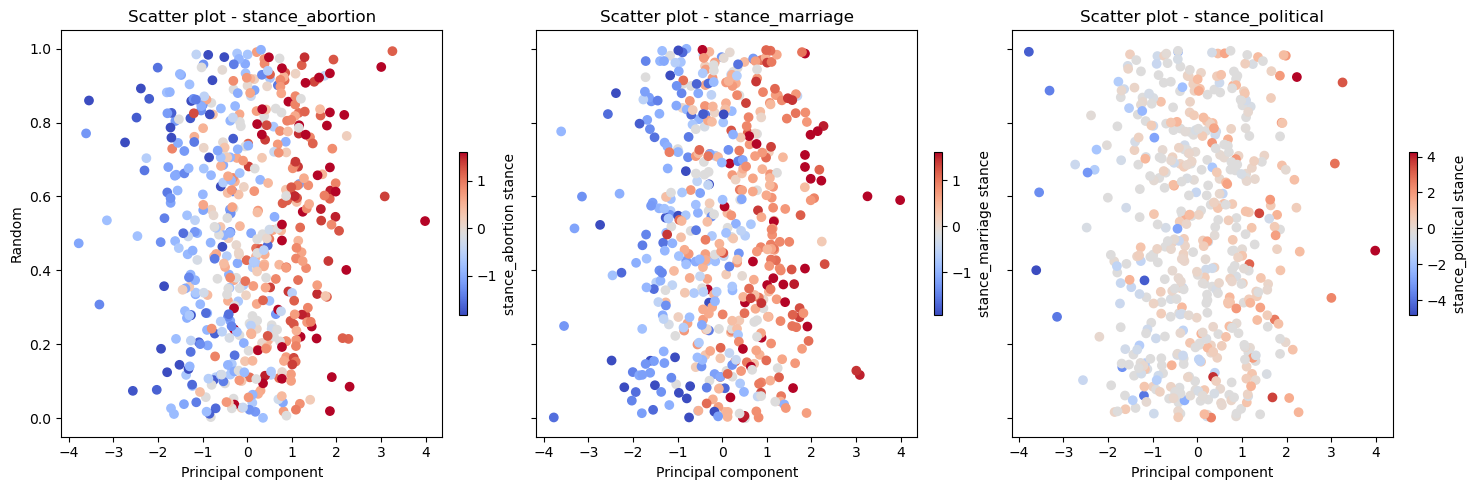

In [22]:
plot_c_subplot(merged_df_reduced, "pca_component", ["stance_abortion", "stance_marriage", "stance_political"])

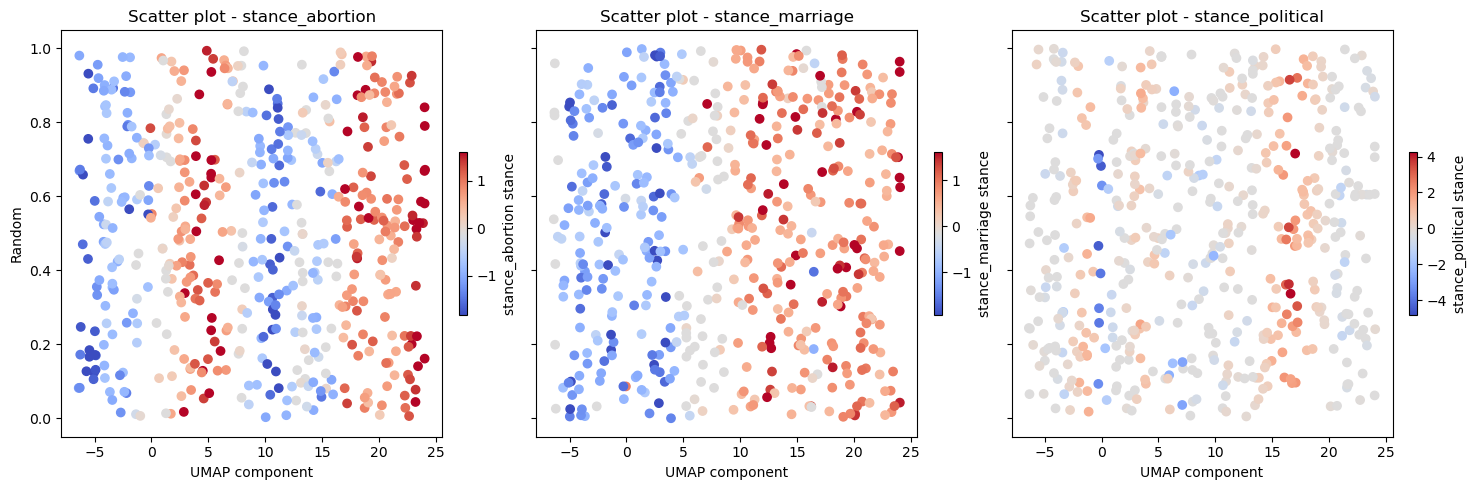

In [23]:
plot_c_subplot(merged_df_reduced, "umap_component", ["stance_abortion", "stance_marriage", "stance_political"])

In [ ]:
pfun.calc_pol2("output_network/network_filtered.csv", "output_network/user_scores_umap.csv")

       src      trg  nij     score
0   798787   254684    1  0.977561
1    15548   430231   16  0.999147
2  1209510   410689   13  0.998674
3  1209510   695649    1  0.915443
4   419460  1234244    3  0.981948
Graph with 511 nodes and 2785 edges
[798787, 254684, 15548, 430231, 1209510, 410689, 695649, 419460, 1234244, 520690, 972375, 521147, 357231, 706029, 608682, 1195573, 494890, 146354, 1032836, 1132377, 1137789, 748633, 21729, 1220350, 1035996, 305666, 1230484, 1153602, 1232506, 1224593, 565896, 747924, 126762, 164809, 594034, 787767, 1008547, 530659, 377344, 958675, 611626, 253973, 1118102, 1137978, 387320, 1147333, 716630, 1170058, 91872, 551205, 871004, 909695, 741859, 1223152, 729200, 1211908, 973627, 1083511, 1208415, 1204545, 817123, 1214536, 1172804, 999706, 1210621, 166171, 246226, 1213277, 816708, 1225587, 1177038, 1212815, 1190564, 1193349, 1213020, 1024416, 413278, 928681, 422090, 1190023, 1051525, 190029, 1137417, 1201133, 198633, 646929, 641233, 942261, 1014902, 108015

np.float64(215.39403942350847)

In [16]:
pfun.calc_pol3("output_network/network_filtered.csv", "output_network/user_scores_umap.csv", "umap_component")

       src      trg  nij     score
0   798787   254684    1  0.977561
1    15548   430231   16  0.999147
2  1209510   410689   13  0.998674
3  1209510   695649    1  0.915443
4   419460  1234244    3  0.981948
Graph with 511 nodes and 2785 edges
[798787, 254684, 15548, 430231, 1209510, 410689, 695649, 419460, 1234244, 520690, 972375, 521147, 357231, 706029, 608682, 1195573, 494890, 146354, 1032836, 1132377, 1137789, 748633, 21729, 1220350, 1035996, 305666, 1230484, 1153602, 1232506, 1224593, 565896, 747924, 126762, 164809, 594034, 787767, 1008547, 530659, 377344, 958675, 611626, 253973, 1118102, 1137978, 387320, 1147333, 716630, 1170058, 91872, 551205, 871004, 909695, 741859, 1223152, 729200, 1211908, 973627, 1083511, 1208415, 1204545, 817123, 1214536, 1172804, 999706, 1210621, 166171, 246226, 1213277, 816708, 1225587, 1177038, 1212815, 1190564, 1193349, 1213020, 1024416, 413278, 928681, 422090, 1190023, 1051525, 190029, 1137417, 1201133, 198633, 646929, 641233, 942261, 1014902, 108015

np.float64(215.39403942350847)